
# FastCCM vs pyEDM — Reproducible Matching



In [1]:

from fastccm import PairwiseCCM, ccm_utils, utils
import numpy as np
import matplotlib.pyplot as plt
import pyEDM
import pandas as pd

np.random.seed(1)


In [2]:

import numpy as np
import matplotlib.pyplot as plt

def plot_ccm_agreement(
    fast_vals,
    pyedm_vals,
    bins=20,
    clamp=(-1, 1),
    figsize=(15, 4),
    title_prefix="FastCCM vs pyEDM",
    show=True,
):
    fast = np.asarray(fast_vals, dtype=float).ravel()
    pyedm = np.asarray(pyedm_vals, dtype=float).ravel()
    if fast.shape != pyedm.shape:
        raise ValueError(f"Shape mismatch: {fast.shape} vs {pyedm.shape}")

    diff    = fast - pyedm
    absdiff = np.abs(diff)

    mae   = absdiff.mean()
    rmse  = np.sqrt((diff**2).mean())
    medae = np.median(absdiff)
    p95   = np.percentile(absdiff, 95)
    mx    = absdiff.max()
    r     = np.corrcoef(pyedm, fast)[0, 1]
    slope, intercept = np.polyfit(pyedm, fast, 1)

    metrics = dict(
        n=len(fast),
        MAE=mae,
        RMSE=rmse,
        median_abs_error=medae,
        p95_abs_error=p95,
        max_abs_error=mx,
        parity_r=r,
        parity_slope=slope,
        parity_intercept=intercept,
    )

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    axes[0].scatter(pyedm, fast, s=20, alpha=0.7)
    if clamp is not None:
        axes[0].plot(clamp, clamp, linestyle="--")
        xg = np.linspace(clamp[0], clamp[1], 200)
        axes[0].set_xlim(*clamp); axes[0].set_ylim(*clamp)
    else:
        lo = min(pyedm.min(), fast.min()); hi = max(pyedm.max(), fast.max())
        axes[0].plot([lo, hi], [lo, hi], linestyle="--")
        xg = np.linspace(lo, hi, 200)
    axes[0].plot(xg, intercept + slope * xg)
    axes[0].set_xlabel("pyEDM correlation"); axes[0].set_ylabel("FastCCM correlation")
    axes[0].set_title(f"{title_prefix} — Parity (r={r:.3f})")

    axes[1].hist(diff, bins=bins)
    axes[1].axvline(0, linestyle="--")
    axes[1].set_xlabel("Error (FastCCM − pyEDM)")
    axes[1].set_ylabel("Count")
    axes[1].set_title(f"Error hist (RMSE={rmse:.2e}, MAE={mae:.2e})")

    mean_vals = 0.5 * (fast + pyedm)
    md  = diff.mean()
    sd  = diff.std(ddof=1)
    axes[2].scatter(mean_vals, diff, s=20, alpha=0.7)
    axes[2].axhline(md, linestyle="-")
    axes[2].axhline(md + 1.96 * sd, linestyle="--")
    axes[2].axhline(md - 1.96 * sd, linestyle="--")
    axes[2].set_xlabel("Mean correlation")
    axes[2].set_ylabel("FastCCM − pyEDM")
    axes[2].set_title("Bland–Altman")

    plt.tight_layout()
    if show:
        plt.show()

    fig2 = plt.figure(figsize=(5, 4))
    plt.hist(np.log10(absdiff + 1e-12), bins=bins)
    plt.xlabel("log10(|FastCCM − pyEDM|)")
    plt.ylabel("Count")
    plt.title("log10 absolute error")
    plt.tight_layout()
    if show:
        plt.show()

    return metrics, (fig, axes)


In [3]:

# --- Helpers for SMap knn + exclusion (+Tp) -----------------------------------
def _safe_knn_smap(lib_obs, E, tau, Tp, exclusion, insample=True, safety_margin=2):
    n_emb = max(0, lib_obs - (E - 1) * tau)
    n_valid = max(1, n_emb - max(0, Tp))
    if insample:
        max_knn = max(1, n_valid - 1 - 2 * exclusion - safety_margin)
    else:
        max_knn = max(1, n_valid - 1 - exclusion - safety_margin)
    return int(max_knn)

def _smap_pyedm_safe_call(df, columns, target, lib, pred, E, tau, Tp, theta, exclusionRadius, knn, insample=True):
    if lib.strip():
        lib_end = int(lib.split()[1])
    else:
        raise ValueError("lib must be 'start end'")
    lib_obs = lib_end

    k_try = _safe_knn_smap(lib_obs=lib_obs, E=E, tau=abs(tau), Tp=Tp, exclusion=exclusionRadius, insample=insample)
    if knn is not None:
        k_try = min(int(knn), k_try)

    ladder = [k_try, max(1, k_try-2), max(1, k_try-5), max(1, k_try-10)]
    for k in ladder:
        try:
            return pyEDM.SMap(
                df, columns=columns, target=target, lib=lib, pred=pred,
                E=E, tau=tau, Tp=Tp, noTime=True, theta=theta,
                exclusionRadius=exclusionRadius, knn=int(k)
            )
        except Exception as _:
            continue

    return pyEDM.SMap(
        df, columns=columns, target=target, lib=lib, pred=pred,
        E=E, tau=tau, Tp=Tp, noTime=True, theta=theta,
        exclusionRadius=exclusionRadius
    )


## Test 1 — CCM, Tp=0, exclusion=4

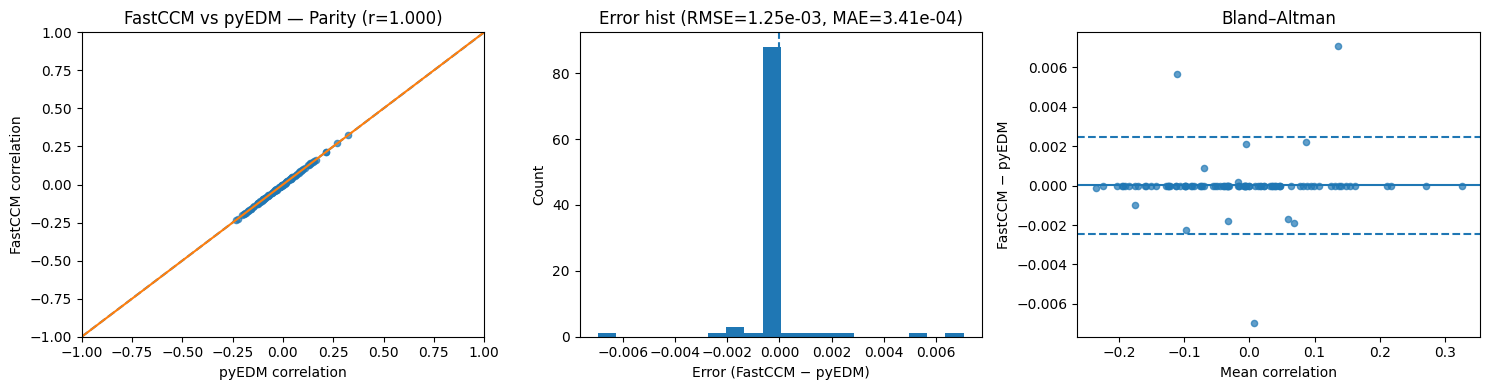

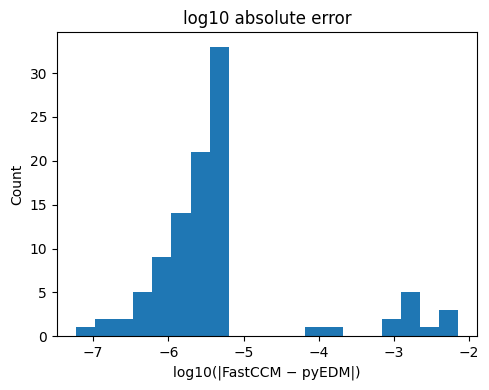

{'n': 100,
 'MAE': np.float64(0.0003407298642283315),
 'RMSE': np.float64(0.0012516035120775425),
 'median_abs_error': np.float64(3.332476615904717e-06),
 'p95_abs_error': np.float64(0.0021170048352554443),
 'max_abs_error': np.float64(0.007077471566200255),
 'parity_r': np.float64(0.9999352797609795),
 'parity_slope': np.float64(1.0005087239175048),
 'parity_intercept': np.float64(3.4087796385651185e-05)}

In [4]:

ccm = PairwiseCCM(device="cpu")
X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(1)
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = utils.embed(X[:,None],E = 3, tau = 1)
    Y_emb = utils.embed(Y[:,None],E = 3, tau = 1)

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                              Y_emb = Y_emb,
                                              library_size = 200,
                                              sample_size = 200, exclusion_window=4, tp=0,
                                              method="simplex",seed=1,trials=1, nbrs_num=4)

    pyedm_ccm_res = pyEDM.CCM(df,columns="X",target="Y",libSizes="200", sample=1, E=3, tau=-1,
                              exclusionRadius=4,seed=1, knn=4, noTime=True).to_numpy()

    X_to_Y_res_FastCCM.append(fast_ccm_res[-1].squeeze())
    X_to_Y_res_pyEDM.append(pyedm_ccm_res[-1,1])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics


## Test 2 — Simplex (in-sample), Tp=1, exclusion=0, knn=10

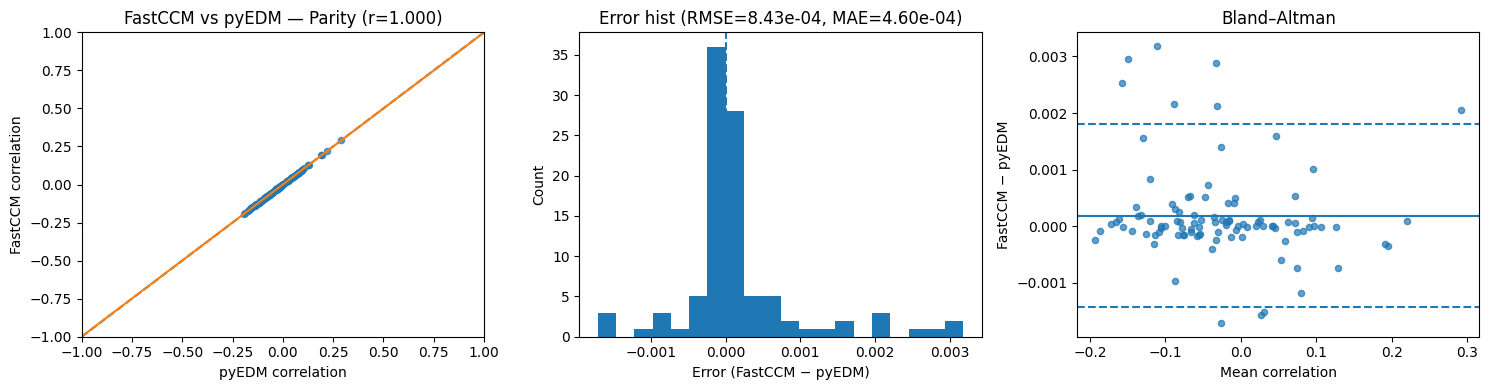

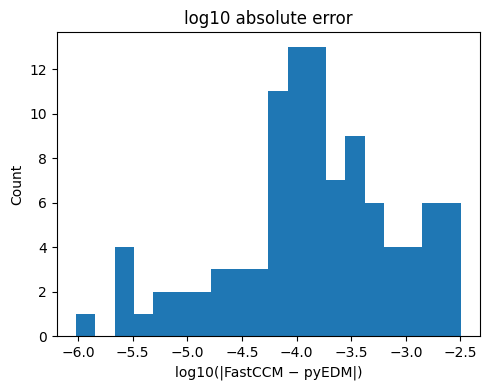

{'n': 100,
 'MAE': np.float64(0.00045959441907373564),
 'RMSE': np.float64(0.0008428368186715213),
 'median_abs_error': np.float64(0.00015181998639120578),
 'p95_abs_error': np.float64(0.0021276027521118525),
 'max_abs_error': np.float64(0.0031815281652578936),
 'parity_r': np.float64(0.9999612958856865),
 'parity_slope': np.float64(0.9986839034412862),
 'parity_intercept': np.float64(0.00014941685967153067)}

In [13]:

X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(1)
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                              Y_emb = Y_emb,
                                              library_size = 200,
                                              sample_size = 200, exclusion_window=0, tp=1,
                                              method="simplex",seed=1, trials=1, nbrs_num=10)

    pyedm_ccm_res = pyEDM.Simplex(df,columns="X",target="Y",lib="1 200", pred="1 200", E=3, tau=-1, Tp=1,
                                  noTime=True, knn=10)

    X_to_Y_res_FastCCM.append(fast_ccm_res[-1].squeeze())
    X_to_Y_res_pyEDM.append(pyedm_ccm_res[["Observations", "Predictions"]].corr()["Predictions"]["Observations"])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics


## Test 3 — Simplex (out-of-sample), Tp=1, exclusion=0, knn=4

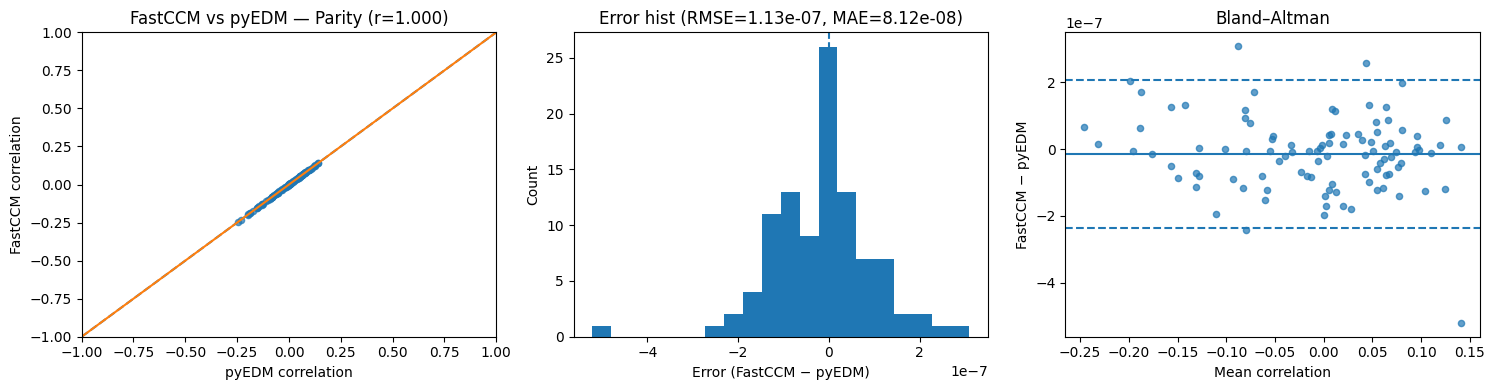

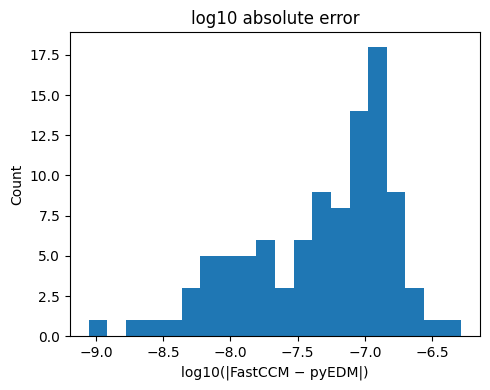

{'n': 100,
 'MAE': np.float64(8.1223715225651e-08),
 'RMSE': np.float64(1.1297669039784455e-07),
 'median_abs_error': np.float64(6.788003724909897e-08),
 'p95_abs_error': np.float64(1.9884135139605628e-07),
 'max_abs_error': np.float64(5.210192904614441e-07),
 'parity_r': np.float64(0.9999999999992433),
 'parity_slope': np.float64(0.9999997945731942),
 'parity_intercept': np.float64(-1.6482065390288628e-08)}

In [6]:

X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(4)
tp = 1
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = Y[None,-X_emb.shape[1]:,None]

    fast_ccm_res = PairwiseCCM("cpu").predict(X_lib_emb = X_emb[:,0:98],
                                              Y_lib_emb = Y_emb[:,0:98],
                                              X_pred_emb = X_emb[:,98:-tp],
                                              library_size = 300, exclusion_window=None, tp=tp,
                                              method="simplex",seed=1, trials=1, nbrs_num=4)

    pyedm_ccm_res = pyEDM.Simplex(df,columns="X",target="Y",lib="1 100", pred="101 200", E=3, tau=-1, Tp=tp,
                                  noTime=True, knn=4, exclusionRadius=0)

    X_to_Y_res_FastCCM.append(np.corrcoef(fast_ccm_res[:,-1,0,0], Y[100 + tp:])[0,1])
    X_to_Y_res_pyEDM.append(pyedm_ccm_res[["Observations", "Predictions"]].corr()["Predictions"]["Observations"])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics


## Test 4 — SMAP (in-sample), Tp=1, exclusion=0, theta=1

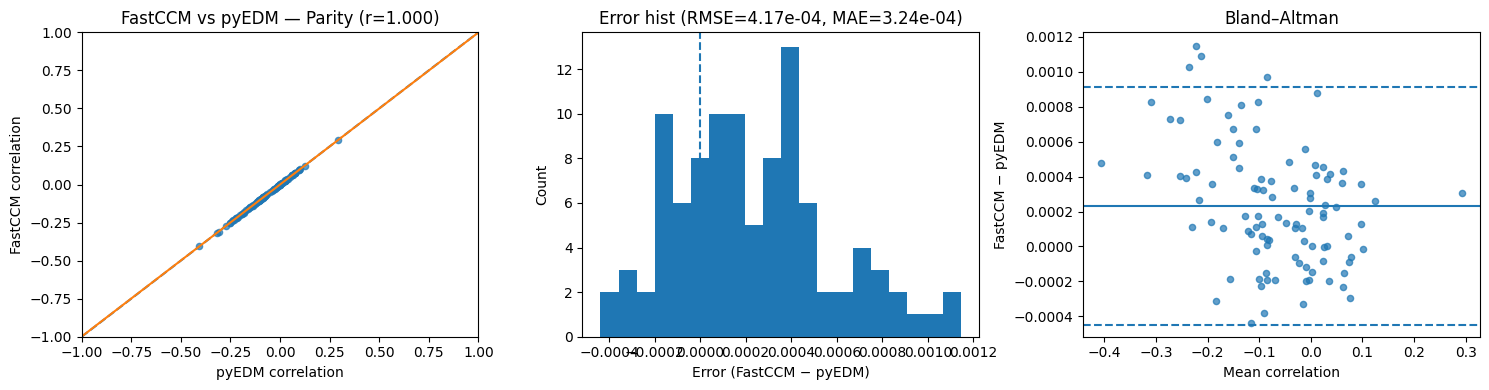

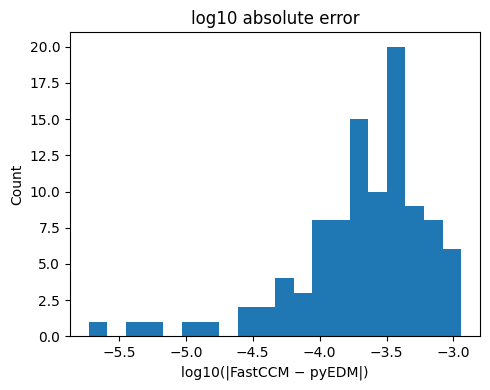

{'n': 100,
 'MAE': np.float64(0.00032388493495459874),
 'RMSE': np.float64(0.00041699570529394356),
 'median_abs_error': np.float64(0.0002627725360818192),
 'p95_abs_error': np.float64(0.0008462538456031691),
 'max_abs_error': np.float64(0.001146062566095729),
 'parity_r': np.float64(0.9999959342477692),
 'parity_slope': np.float64(0.9988212558869686),
 'parity_intercept': np.float64(0.00015119858810171976)}

In [7]:

X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(1)
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                              Y_emb = Y_emb,
                                              library_size = 200,
                                              sample_size = 200, exclusion_window=0, tp=1,
                                              method="smap",seed=1, trials=1, theta=1)

    pyedm_ccm_res = pyEDM.SMap(df,columns="X",target="Y",lib="1 200", pred="1 200", E=3, tau=-1, theta=1, Tp=1,
                               noTime=True,exclusionRadius=0)
    
    X_to_Y_res_FastCCM.append(fast_ccm_res[-1].squeeze())
    X_to_Y_res_pyEDM.append(pyedm_ccm_res["predictions"][["Observations", "Predictions"]].corr()["Predictions"]["Observations"])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics


## Test 5 — SMAP (in-sample), Tp=1, exclusion=5, theta=1 (patched knn)

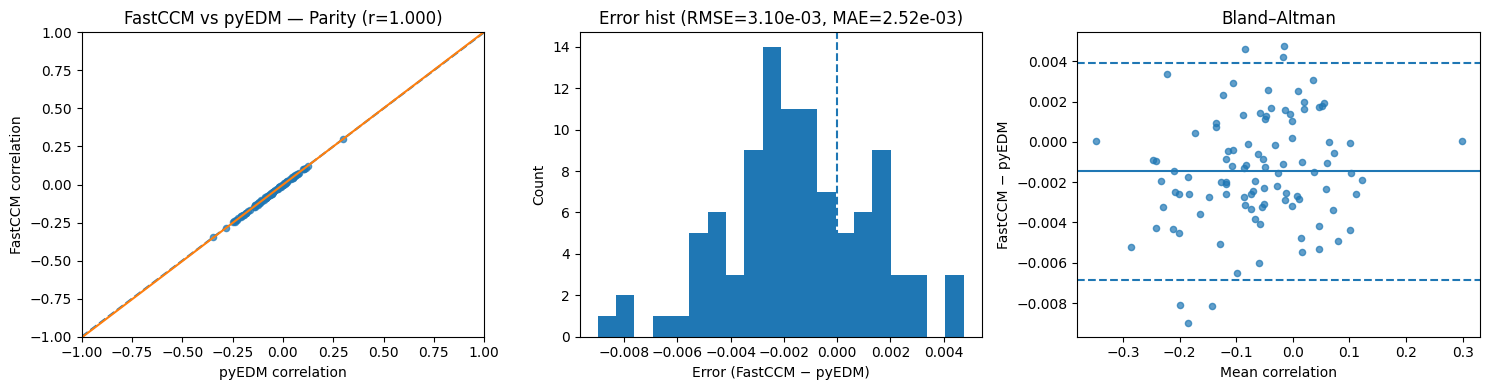

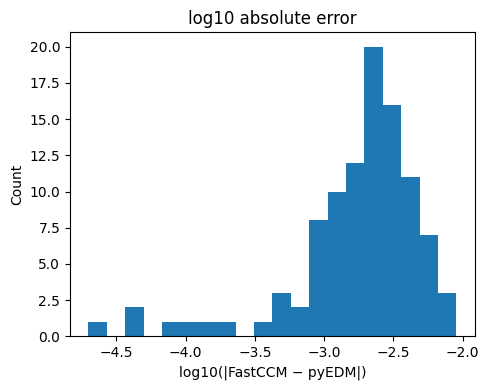

{'n': 100,
 'MAE': np.float64(0.0025164431897390254),
 'RMSE': np.float64(0.0030962163425936368),
 'median_abs_error': np.float64(0.0022200151798645543),
 'p95_abs_error': np.float64(0.005488777995857446),
 'max_abs_error': np.float64(0.008986305849135984),
 'parity_r': np.float64(0.9996739238116149),
 'parity_slope': np.float64(1.0044572798829465),
 'parity_intercept': np.float64(-0.001187923786659484)}

In [8]:

X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(1)
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                              Y_emb = Y_emb,
                                              library_size = 200,
                                              sample_size = 200, exclusion_window=5, tp=1,
                                              method="smap",seed=1, trials=1, theta=1)

    _knn = _safe_knn_smap(lib_obs=200, E=3, tau=1, Tp=1, exclusion=5, insample=True, safety_margin=0)
    pyedm_ccm_res = _smap_pyedm_safe_call(
        df, columns="X", target="Y",
        lib="1 200", pred="1 200",
        E=3, tau=-1, Tp=1, theta=1,
        exclusionRadius=5, knn=_knn, insample=True
    )
    
    X_to_Y_res_FastCCM.append(fast_ccm_res[-1].squeeze())
    X_to_Y_res_pyEDM.append(pyedm_ccm_res["predictions"][["Observations", "Predictions"]].corr()["Predictions"]["Observations"])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics


## Test 6 — SMAP (out-of-sample), Tp=1, exclusion=0, theta=2

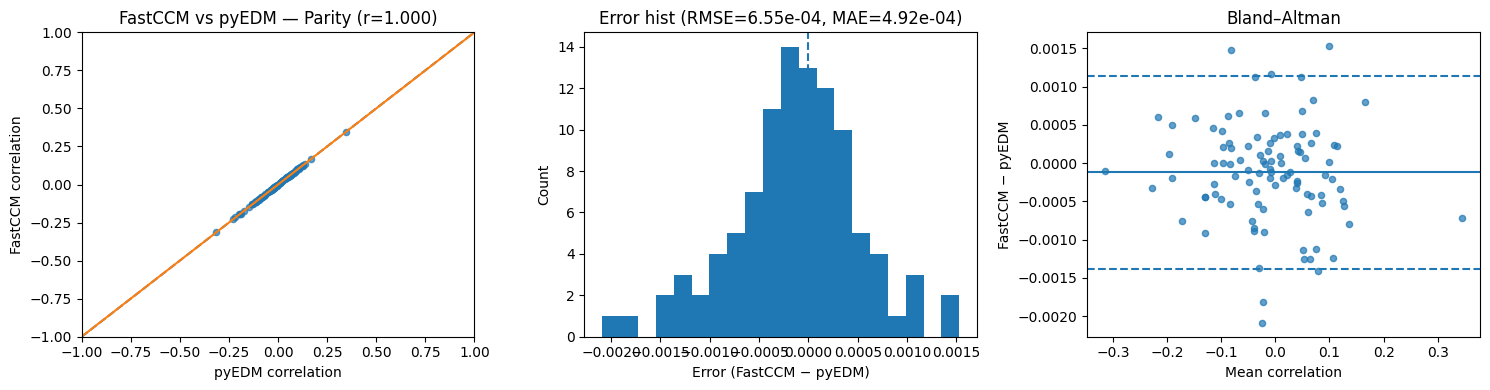

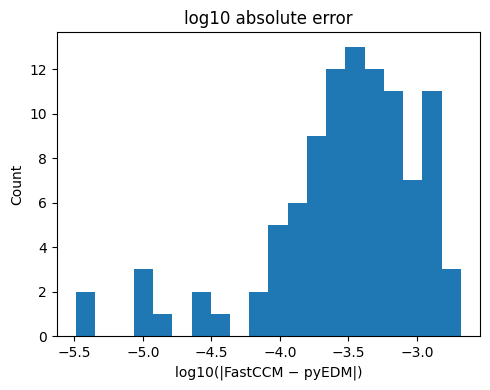

{'n': 100,
 'MAE': np.float64(0.0004924142239336772),
 'RMSE': np.float64(0.0006553003205950373),
 'median_abs_error': np.float64(0.00037251076681804607),
 'p95_abs_error': np.float64(0.0013760682533299905),
 'max_abs_error': np.float64(0.0020887907884160686),
 'parity_r': np.float64(0.9999782171678935),
 'parity_slope': np.float64(0.9992738491968863),
 'parity_intercept': np.float64(-0.00013005263527620655)}

In [9]:

X_to_Y_res_FastCCM, X_to_Y_res_pyEDM = [], []

np.random.seed(1)
tp = 1
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").predict(X_lib_emb = X_emb[:,0:99],
                                              Y_lib_emb = Y_emb[:,0:99],
                                              X_pred_emb = X_emb[:,98:-tp],
                                              library_size = 200, exclusion_window=None, tp=tp,
                                              method="smap",seed=1, trials=1, theta=2)

    pyedm_ccm_res = pyEDM.SMap(df,columns="X",target="Y",lib="1 101", pred="101 200", E=3, tau=-1, Tp=tp,
                               noTime=True, theta=2, exclusionRadius=0)

    X_to_Y_res_FastCCM.append(np.corrcoef(fast_ccm_res[:,-1,0,0], Y_emb[0,-(100-tp):,-1])[0,1])
    X_to_Y_res_pyEDM.append(pyedm_ccm_res["predictions"][["Observations", "Predictions"]].corr()["Predictions"]["Observations"])

metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
metrics
